In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
from bicycle import *
from bicycle_control import *

In [3]:
import sys 
sys.path.append('..')
from codeprint import RawCode

# Pure pursuit Control

### Bicycle Class : BicycleModel + Visualization

In [4]:
# 3 bicycles
bicycles = [Bicycle(L=2, dt=0.1, model_type='rear') for _ in range(3)]
for bicycle in bicycles:
    bicycle.view = [-5, 20, -5, 20]


### Bicycle : set starting point

In [5]:
start1 = [-2,2, -1]
start2 = [8,10,-0.5]
start3 = [3,-4,0.5]
starts = [start1, start2, start3]
for bicycle, start in zip(bicycles, starts):
    bicycle.set_state(start,0)


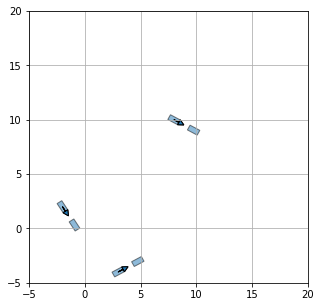

In [6]:
#visualize
fig, ax = plt.subplots(figsize=[5,5])
for bicycle in bicycles:
    bicycle.show()

### Path

In [7]:
def draw_line(line):
    ax = plt.gca()
    xx = np.arange(-20,20,0.1)
    ax.plot(xx, line(xx), 'k--')
a, b, c = -1, 2, 3
line = lambda x: -a*x/b - c/b

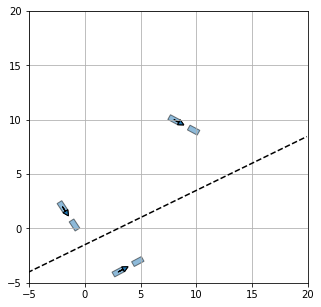

In [8]:
fig, ax = plt.subplots(figsize=[5,5])
draw_line(line)
for bicycle in bicycles:
    bicycle.show()

## Pure Pursuit Control Class

In [9]:
code = RawCode('bicycle_control.py')
code.show('PurePursuit')

class PurePursuit():
    def __init__(self, line_coeff, L, lookahead_distance):
        self.line_coeff = line_coeff #a, b, c from ax + by + c=0
        self.L = L
        self.ld = lookahead_distance

    def get_nearest_point(self, curr_point):
        normal_vector = np.array(self.line_coeff[:2])/LA.norm(self.line_coeff[:2])
        point_on_line = np.array([-self.line_coeff[2] / self.line_coeff[0], 0]) # y=0
        vector = point_on_line - curr_point
        d = vector @ normal_vector
        return curr_point + d * normal_vector

    def get_lookahead_point(self, curr_point):
        a, b, c = self.line_coeff
        point_on_line = np.array([0, -c/b]) # y=0
        nearest_point = self.get_nearest_point(curr_point)
        dist = LA.norm(curr_point - nearest_point)
        if abs(dist) > self.ld:
            return nearest_point
        else:
            normal_vector_through_line = (nearest_point - point_on_line)/LA.norm(nearest_point - point_on_line)
            if normal_vect

In [10]:
# a, b, c is line coeffs
p = PurePursuit([a, b, c], L=bicycle.L, lookahead_distance =5)
#stanley = Stanley([a, b, c], gain=0.5, gamma_max=np.pi/4)

### Simulation

In [11]:
def bicycle_simulation(bicycle, start_state, max_iter):
    # make dataframe for recording simulation
    state_names = ['x','y','theta']
    control_input_names = ['v','gamma']
    lookahead_point_pos = ['lp_x', 'lp_y']
    sim = pd.DataFrame(columns=state_names+control_input_names+lookahead_point_pos)
    
    # init
    sim.loc[0,state_names] = start_state
    curr_state = sim.loc[0,state_names]
    v = 2 # fixed velocity
    
    # loop
    for i in range(100):
        lp_x, lp_y = p.get_lookahead_point(curr_state[:2])
        gamma = p.ctrl(curr_state)
        next_state = bicycle.model(curr_state, v, gamma)
        
        # record simulation
        idx = len(sim)
        sim.loc[idx,state_names] = next_state
        sim.loc[idx,control_input_names] = v, gamma
        sim.loc[idx,['lp_x', 'lp_y']] = lp_x, lp_y
        
        # update state
        curr_state = next_state
    return sim

In [12]:
max_iter = 100
sims = [bicycle_simulation(bicycle, start, max_iter) 
        for bicycle, start in zip(bicycles, starts)]

### Visualization

In [13]:
def visualization(sim):
    # starting position
    start = sim.loc[0,['x','y','theta']]
    bicycle.set_state(start,0)
    bicycle.show()
    # end position
    final_state = sim.iloc[-1][['x','y','theta']].tolist()
    bicycle.set_state(final_state,0)
    bicycle.show()
    # path
    plt.scatter(sim.loc[:,'x'], sim.loc[:,'y'], s=1);

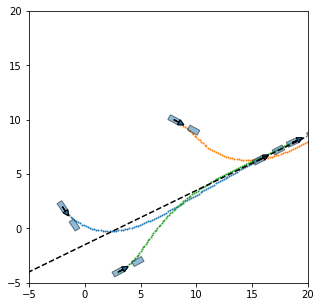

In [14]:
fig, ax = plt.subplots(figsize=[5,5])
for sim in sims:
    visualization(sim)
draw_line(line)

[-1.891939538826372, 1.8317058030384206]
[-0.18086931 -1.59043465]


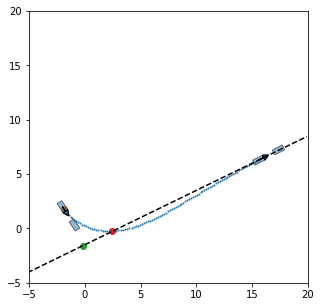

In [15]:
fig, ax = plt.subplots(figsize=[5,5])
sims_idx = 0
visualization(sims[sims_idx])
draw_line(line)

sim = sims[sims_idx]
idx = 1
curr_point = sim.loc[idx,['x','y']].to_list()
nearest = p.get_nearest_point(curr_point)
la_point = sim.loc[idx,['lp_x','lp_y']].to_list()
plt.scatter(*curr_point)
plt.scatter(*nearest)
plt.scatter(*la_point)
print(curr_point)
print(nearest)

### draw animation

In [16]:
def init(bicycle, sim):
    start = sim.loc[0,['x','y','theta']].tolist()
    bicycle.set_state(start,0)
    bicycle.show()

In [17]:
def update(bicycle, sim, i, color='k'):
    row = sim.loc[i,:]
    state = row.loc[['x','y','theta']].to_numpy()
    gamma = row.loc['gamma']
    bicycle.set_state(state, gamma)
    bicycle.update();
    path = plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1, color=color)
    lp = plt.scatter(sim.loc[i,'lp_x'], sim.loc[i,'lp_y'], color=color)
    return path, lp

In [18]:
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS

In [19]:
from animake import AniMaker
anim = AniMaker()

image added:  100


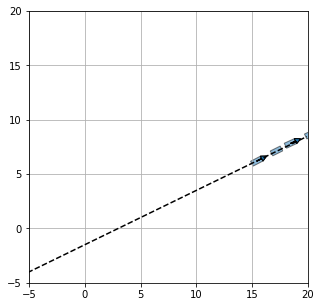

In [20]:
# init animation
fig, ax = plt.subplots(figsize=[5,5])
for bicycle, sim in zip(bicycles, sims):
    init(bicycle, sim)
draw_line(line)

# update animation and get snapshots
for i in range(100):
    temp = []
    for bicycle, sim, color in zip(bicycles, sims, colors):
        path, lp = update(bicycle, sim, i, color)
        temp.append(path)
        temp.append(lp)
    anim.set_snapshot()
    for item in temp:
        item.remove()


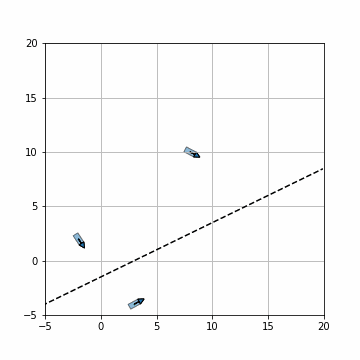

In [21]:
anim.make_gif('out_pure_pursuit.gif')
Image(filename="out_pure_pursuit.gif")